### Compare to V13
- LR 1e-4
- Use cutmix alpha 0.5

In [ ]:
!nvidia-smi

Mon Feb 14 01:12:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   30C    P0    54W / 300W |   2556MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   30C    P0    41W / 300W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True) 

In [ ]:
import torch
torch.__version__

'1.7.1'

In [ ]:
# try:
#     import timm
# except:
#     !pip install timm
#     # !pip install effdet
#     !pip install --upgrade albumentations==0.4.6
#     # !pip install ensemble-boxes==1.0.6
#     # !pip install fastcore==1.3.20
#     !pip install warmup_scheduler
#     !pip install --force-reinstall kaggle
#     raise Exception('Need to restart exception')

In [ ]:
# import os
# if(not os.path.exists('/content/train_images')):
#     !mkdir ~/.kaggle
#     !cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
#     !chmod 600 ~/.kaggle/kaggle.json

#     !kaggle competitions download -c tensorflow-great-barrier-reef
#     !unzip -q tensorflow-great-barrier-reef.zip -d /content

#     !unzip /content/gdrive/MyDrive/Kaggle/COTS/data/crawled_cots.zip

In [ ]:
import sys
sys.path.append('/tf/COTS/utils/')
# from train_net import Trainer
from general import seed_torch
# from metric import metric_calculate, rle_decode, rle_encode, check_overlap, get_masks

In [ ]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
from torch.optim import AdamW
from torchvision.ops import box_iou


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
ROOT_FOLDER = '/tf/COTS/'
DATA_DIR = f'{ROOT_FOLDER}/data/train_images'
EXT_DATA_DIR = f'{ROOT_FOLDER}/data/crawled_cots/images'
RUN_FOLDS = [2]
BATCH_SIZE = 128
IMG_SIZE = 128
SAMPLE = None
SEED = 67
BASE_LR = 1e-4
WARMUP_FACTOR = 10
PATIENCE = 10
NUM_EPOCHS = 50
NUM_WORKERS = 4
DEVICE = 'cuda:0'
MODEL_DIR = f'{ROOT_FOLDER}/namnt54/models/'

CANDIDATES = [
    {
        'model_architecture':'tf_efficientnet_b7_ns',
        'backbone_pretrained':'/tf/COTS/namnt54/pretrained_models/tf_efficientnet_b7_ns-1dbc32de.pth',
        'ver_note':'clf_v14.1_size128_cutmix',
    },
]


In [ ]:
seed_torch(SEED) # set initial seed

In [ ]:
df = pd.read_csv(os.path.join(ROOT_FOLDER, 'data', 'cots_more_balanced_cv_split_v2_marking_duplicates_all.csv'))

df["Width"]=1280
df["Height"]=720

In [ ]:
ext_df = pd.read_csv(f'{ROOT_FOLDER}/data/crawled_cots/crawled_cots_data.csv')

In [ ]:
ext_df['label'] = 1
ext_df['score'] = 1
ext_df['x1'] = 0
ext_df['y1'] = 0
ext_df['x2'] = 9999
ext_df['y2'] = 9999

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, random_state=SEED, shuffle=True)
i = 0
for train_index, valid_index in kfold.split(ext_df['x1'], ext_df['label']):
    ext_df.loc[valid_index, 'fold'] = i
    i+=1

In [ ]:
ext_df['image_path'] = f'{EXT_DATA_DIR}/' + ext_df['image_name']

In [ ]:
# plt.imread(ext_df.image_path.iloc[0])

In [ ]:
len(df)

23501

In [ ]:
len(ext_df)

117

In [ ]:
print('Number of image having annotation:\n', df.groupby('fold').n_annotations.count())
print('\nNumber of annotations:\n', df.groupby('fold').n_annotations.sum())

Number of image having annotation:
 fold
0.0    4764
1.0    4640
2.0    4619
3.0    4656
4.0    4822
Name: n_annotations, dtype: int64

Number of annotations:
 fold
0.0    2753
1.0    2100
2.0    2988
3.0    2260
4.0    1797
Name: n_annotations, dtype: int64


In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

In [ ]:
import ast
df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x))
df['bboxes'] = df.annotations.apply(get_bbox)

In [ ]:
len(df)

23501

# Prepare data

## Generate hard samples

In [ ]:
import pickle
with open(f'{ROOT_FOLDER}/train_predictions/truongbn2/yolov5s6_i3648_train_fold{RUN_FOLDS[0]}_0.1.pkl', 'rb') as f:
    yolo5_train_hard_mining = pickle.load(f)

with open(f'{ROOT_FOLDER}/valid_predictions/truongbn2/yolov5s6_i3648_fold{RUN_FOLDS[0]}_0.1ConfScore.pkl', 'rb') as f:
    yolo5_valid_hard_mining = pickle.load(f)
    
with open(f'{ROOT_FOLDER}/train_predictions/khanhvd/yolor_w6_train_fold{RUN_FOLDS[0]}.pkl', 'rb') as f:
    yolor_train_hard_mining = pickle.load(f)

with open(f'{ROOT_FOLDER}/valid_predictions/khanhvd/yolor_w6_valid_fold{RUN_FOLDS[0]}.pkl', 'rb') as f:
    yolor_valid_hard_mining = pickle.load(f)    
    
with open(f'{ROOT_FOLDER}/train_predictions/tuyendt23/yolox_l_train{RUN_FOLDS[0]}_conf0.05.pickle', 'rb') as f:
    yoloxl_train_hard_mining = pickle.load(f)

with open(f'{ROOT_FOLDER}/valid_predictions/tuyendt23/yolox_l_valid{RUN_FOLDS[0]}_conf0.05.pickle', 'rb') as f:
    yoloxl_valid_hard_mining = pickle.load(f)   
    
with open(f'{ROOT_FOLDER}/train_predictions/namnt54/fasterrcnn_v6_Rs200_rm_dups_fold{RUN_FOLDS[0]}_size1024_conf0.1.pkl', 'rb') as f:
    fasterr_train_hard_mining = pickle.load(f)

with open(f'{ROOT_FOLDER}/valid_predictions/namnt54/fasterrcnn_v6_Rs200_rm_dups_fold{RUN_FOLDS[0]}_size1024_conf0.1.pkl', 'rb') as f:
    fasterr_valid_hard_mining = pickle.load(f)

In [ ]:
# ls /home/ubuntu/COTS//valid_predictions/tuyendt23/

In [ ]:
len(fasterr_train_hard_mining), len(fasterr_valid_hard_mining)

(18882, 4619)

In [ ]:
len(yolo5_train_hard_mining), len(yolo5_valid_hard_mining)

(18882, 4619)

In [ ]:
len(yolor_train_hard_mining), len(yolor_valid_hard_mining)

(18882, 4619)

In [ ]:
len(yoloxl_train_hard_mining), len(yoloxl_valid_hard_mining)

(18882, 4619)

In [ ]:
df_filtered = df[df['use_frame_threshold_5.0']]

# df_filtered = df.copy()

In [ ]:
df_filtered.has_annotations.value_counts()

True    2708
Name: has_annotations, dtype: int64

In [ ]:
print('Number of image having annotation:\n', df_filtered.groupby('fold').n_annotations.count())
print('\nNumber of annotations:\n', df_filtered.groupby('fold').n_annotations.sum())

Number of image having annotation:
 fold
0.0    558
1.0    568
2.0    578
3.0    529
4.0    475
Name: n_annotations, dtype: int64

Number of annotations:
 fold
0.0    1769
1.0    1309
2.0    1884
3.0    1242
4.0     784
Name: n_annotations, dtype: int64


In [ ]:
IOU_THRESH = 0.3

In [ ]:
def gen_sample_df(train_hard_mining, valid_hard_mining):
    list_image_ids = []
    list_confs = []
    list_boxes = []
    list_aspect_ratios = []
    list_areas= []
    list_is_tp = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        image_id = row['image_id']
        true_boxes = [ [d['x'], d['y'], d['x']+d['width'], d['y']+d['height']] for d in row['annotations'] ]
        true_boxes = torch.tensor(true_boxes)

        if image_id in train_hard_mining:
            predicted_boxes = train_hard_mining[image_id].copy()
        elif image_id in valid_hard_mining:
            predicted_boxes = valid_hard_mining[image_id].copy()

        if len(predicted_boxes) == 0:
            continue

        # aspect_ratios = predicted_boxes[:,3] / predicted_boxes[:,4]
        # areas = predicted_boxes[:,3] * predicted_boxes[:,4]

        predicted_boxes[:,3] += predicted_boxes[:,1]
        predicted_boxes[:,4] += predicted_boxes[:,2]
        predicted_boxes = torch.tensor(predicted_boxes)

        if len(true_boxes) > 0:
            ious = box_iou(predicted_boxes[:,1:], true_boxes)
            max_ious = ious.max(axis=1)[0]
            is_TP = max_ious >= IOU_THRESH
            list_is_tp += is_TP.tolist()   
        else:
            list_is_tp += [0] * len(predicted_boxes)   

            # list_aspect_ratios += aspect_ratios.tolist()
            # list_areas += areas.tolist()

        list_image_ids += [image_id]*len(predicted_boxes)
        list_confs += predicted_boxes[:,0].tolist()
        list_boxes += predicted_boxes[:,1:].tolist()

    sampling_df = pd.DataFrame({'image_id':list_image_ids, 'score':list_confs, 'box':list_boxes, 'label':list_is_tp}).sort_values('score', ascending=False)
    sampling_df['label'] = sampling_df['label'].astype(int)

    sampling_df['x1'] = sampling_df['box'].map(lambda x: x[0])
    sampling_df['y1'] = sampling_df['box'].map(lambda x: x[1])
    sampling_df['x2'] = sampling_df['box'].map(lambda x: x[2])
    sampling_df['y2'] = sampling_df['box'].map(lambda x: x[3])
    
    return sampling_df

In [ ]:
yolo5_sampling_df = gen_sample_df(yolo5_train_hard_mining, yolo5_valid_hard_mining)

100%|██████████| 23501/23501 [00:05<00:00, 3965.34it/s]


In [ ]:
yolor_sampling_df = gen_sample_df(yolor_train_hard_mining, yolor_valid_hard_mining)

100%|██████████| 23501/23501 [00:05<00:00, 4495.52it/s]


In [ ]:
yoloxl_sampling_df = gen_sample_df(yoloxl_train_hard_mining, yoloxl_valid_hard_mining)

100%|██████████| 23501/23501 [00:06<00:00, 3804.25it/s]


In [ ]:
fasterr_sampling_df = gen_sample_df(fasterr_train_hard_mining, fasterr_valid_hard_mining)

100%|██████████| 23501/23501 [00:06<00:00, 3455.00it/s]


In [ ]:
fasterr_sampling_df

,image_id,score,box,label,x1,y1,x2,y2
9575,0-9387,0.998406,"[572.34619140625, 394.6769714355469, 646.92736...",1,572.346191,394.676971,646.927368,458.275452
9381,0-9348,0.998197,"[759.6561889648438, 202.26495361328125, 815.56...",1,759.656189,202.264954,815.560059,252.985397
9572,0-9386,0.998166,"[574.5447387695312, 383.25115966796875, 647.70...",1,574.544739,383.251160,647.707153,444.422333
9462,0-9364,0.998165,"[684.3927612304688, 392.01202392578125, 755.00...",1,684.392761,392.012024,755.001587,451.728119
9409,0-9354,0.998105,"[735.9552001953125, 270.4202575683594, 796.078...",1,735.955200,270.420258,796.078491,324.373169
...,...,...,...,...,...,...,...,...
41644,2-6340,0.100004,"[1256.632568359375, 650.8939819335938, 1279.60...",0,1256.632568,650.893982,1279.608154,677.983459
21869,1-5319,0.100004,"[388.0474853515625, 169.55650329589844, 434.78...",1,388.047485,169.556503,434.782990,217.193573
85894,1-4383,0.100003,"[557.9508666992188, 612.6102905273438, 582.667...",0,557.950867,612.610291,582.667664,633.189148
66025,0-9212,0.100001,"[465.1842346191406, 291.7619323730469, 483.884...",0,465.184235,291.761932,483.884796,309.246033


In [ ]:
yolo5_sampling_df

,image_id,score,box,label,x1,y1,x2,y2
13869,2-5390,0.849609,"[642.0, 650.0, 696.0, 704.0]",1,642.0,650.0,696.0,704.0
13847,2-5380,0.845215,"[607.0, 608.0, 660.0, 660.0]",1,607.0,608.0,660.0,660.0
3304,0-9530,0.843262,"[0.0, 327.0, 58.0, 380.0]",1,0.0,327.0,58.0,380.0
758,0-1912,0.840820,"[663.0, 339.0, 719.0, 392.0]",1,663.0,339.0,719.0,392.0
13840,2-5377,0.836914,"[623.0, 574.0, 672.0, 624.0]",1,623.0,574.0,672.0,624.0
...,...,...,...,...,...,...,...,...
30850,2-8097,0.100037,"[558.0, 601.0, 602.0, 657.0]",0,558.0,601.0,602.0,657.0
20215,1-588,0.100037,"[226.0, 257.0, 298.0, 324.0]",0,226.0,257.0,298.0,324.0
23224,1-9628,0.100037,"[650.0, 650.0, 682.0, 679.0]",0,650.0,650.0,682.0,679.0
20545,1-810,0.100037,"[693.0, 160.0, 785.0, 234.0]",0,693.0,160.0,785.0,234.0


In [ ]:
yolor_sampling_df

,image_id,score,box,label,x1,y1,x2,y2
15031,2-5781,0.407253,"[616.0, 650.0, 675.0, 701.0]",1,616.0,650.0,675.0,701.0
14472,2-5767,0.404603,"[653.0, 535.0, 712.0, 591.0]",1,653.0,535.0,712.0,591.0
14921,2-5778,0.404455,"[634.0, 611.0, 693.0, 663.0]",1,634.0,611.0,693.0,663.0
13931,2-5753,0.403033,"[547.0, 487.0, 602.0, 535.0]",1,547.0,487.0,602.0,535.0
14688,2-5772,0.402958,"[636.0, 539.0, 693.0, 588.0]",1,636.0,539.0,693.0,588.0
...,...,...,...,...,...,...,...,...
17806,1-5138,0.020006,"[759.0, 503.0, 798.0, 542.0]",0,759.0,503.0,798.0,542.0
3520,0-9747,0.020002,"[278.0, 507.0, 343.0, 566.0]",1,278.0,507.0,343.0,566.0
15066,2-5781,0.020001,"[916.0, 312.0, 970.0, 366.0]",1,916.0,312.0,970.0,366.0
362,0-352,0.020001,"[266.0, 209.0, 308.0, 247.0]",1,266.0,209.0,308.0,247.0


In [ ]:
yoloxl_sampling_df

,image_id,score,box,label,x1,y1,x2,y2
17522,2-5745,0.851003,"[523.0, 389.0, 565.0, 427.0]",1,523.0,389.0,565.0,427.0
17820,2-5760,0.850196,"[592.0, 460.0, 638.0, 502.0]",1,592.0,460.0,638.0,502.0
17743,2-5756,0.848193,"[553.0, 461.0, 600.0, 504.0]",1,553.0,461.0,600.0,504.0
17702,2-5754,0.847262,"[532.0, 459.0, 576.0, 500.0]",1,532.0,459.0,576.0,500.0
17580,2-5748,0.846729,"[504.0, 417.0, 548.0, 456.0]",1,504.0,417.0,548.0,456.0
...,...,...,...,...,...,...,...,...
46769,2-9956,0.050007,"[66.0, 454.0, 108.0, 495.0]",0,66.0,454.0,108.0,495.0
32943,1-8762,0.050006,"[81.0, 0.0, 114.0, 19.0]",0,81.0,0.0,114.0,19.0
34278,1-10058,0.050005,"[552.0, 261.0, 584.0, 290.0]",0,552.0,261.0,584.0,290.0
5759,1-854,0.050003,"[10.0, 374.0, 50.0, 410.0]",0,10.0,374.0,50.0,410.0


In [ ]:
yolo5_hard_pos_df = yolo5_sampling_df[(yolo5_sampling_df.label==1)
#  & (yolo5_sampling_df.score < 0.2)
 ]
yolo5_hard_neg_df = yolo5_sampling_df[(yolo5_sampling_df.label==0)
#  & (yolo5_sampling_df.score > 0.8)
 ]

yolor_hard_pos_df = yolor_sampling_df[(yolor_sampling_df.label==1)
 & (yolor_sampling_df.score < 0.05)
 ]
yolor_hard_neg_df = yolor_sampling_df[(yolor_sampling_df.label==0)
 & (yolor_sampling_df.score > 0.05)
 ]

yoloxl_hard_pos_df = yoloxl_sampling_df[(yoloxl_sampling_df.label==1)
 & (yoloxl_sampling_df.score < 0.2)
 ]
yoloxl_hard_neg_df = yoloxl_sampling_df[(yoloxl_sampling_df.label==0)
 & (yolor_sampling_df.score > 0.2)
 ]

fasterr_hard_pos_df = fasterr_sampling_df[(fasterr_sampling_df.label==1)
 & (fasterr_sampling_df.score < 0.3)
 ]
fasterr_hard_neg_df = fasterr_sampling_df[(fasterr_sampling_df.label==0)
 & (fasterr_sampling_df.score > 0.7)
 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
# yolor_sampling_df.score.plot(kind='box')

In [ ]:
len(yolo5_hard_pos_df), len(yolo5_hard_neg_df)

(11233, 21995)

In [ ]:
len(yolor_hard_pos_df), len(yolor_hard_neg_df)

(5106, 1297)

In [ ]:
len(yoloxl_hard_pos_df), len(yoloxl_hard_neg_df)

(1271, 1322)

In [ ]:
len(fasterr_hard_pos_df), len(fasterr_hard_neg_df)

(2270, 11130)

In [ ]:
# image_id = '1-9348'
# video_id, video_frame = image_id.split('-')
# video_id, video_frame = int(video_id), int(video_frame)
# path = f'{DATA_DIR}/video_{video_id}/{video_frame}.jpg'

# x1,y1,x2,y2 = np.array(sampling_df[sampling_df.image_id==image_id].box.sample(1).iloc[0]).astype(int)

# img = plt.imread(path)
# img = cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0),2)

In [ ]:
# plt.figure(figsize=(20,10))
# plt.imshow(img)

## Generate easy samples

In [ ]:
NEG_SAMPLE_BOX_SIZE_RANGE = [24, 96]
IOU_THRESH = 0.3
N_NEG_PER_IMG = 1

WIDTH = 1280
HEIGHT = 720

list_neg_boxes = []
# list_image_ids = []

for i, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    pos_boxes = [ [d['x'], d['y'], d['x']+d['width'], d['y']+d['height']] for d in row['annotations'] ]
    pos_boxes = torch.tensor(pos_boxes)
    
    x1_arr = torch.randint(0, WIDTH, (N_NEG_PER_IMG, 1))
    y1_arr = torch.randint(0, HEIGHT, (N_NEG_PER_IMG, 1))

    w_arr = torch.FloatTensor(N_NEG_PER_IMG, 1).uniform_(NEG_SAMPLE_BOX_SIZE_RANGE[0], NEG_SAMPLE_BOX_SIZE_RANGE[1]).int()
    h_arr = torch.FloatTensor(N_NEG_PER_IMG, 1).uniform_(NEG_SAMPLE_BOX_SIZE_RANGE[0], NEG_SAMPLE_BOX_SIZE_RANGE[1]).int()

    x2_arr = x1_arr + w_arr 
    y2_arr = y1_arr + h_arr

    neg_boxes = torch.cat([x1_arr, y1_arr, x2_arr, y2_arr], axis=1)

    if len(pos_boxes) > 0:
        ious = box_iou(pos_boxes, neg_boxes)

        max_ious = ious.max(axis=0)[0]

        take = max_ious <= IOU_THRESH

        taken_neg_boxes = neg_boxes[take]
    else:
        taken_neg_boxes = neg_boxes 

    list_neg_boxes.append(taken_neg_boxes.tolist())
    # list_image_ids.append(row['image_id'])

100%|██████████| 2708/2708 [00:01<00:00, 1960.80it/s]


In [ ]:
df_filtered['neg_annotations'] = list_neg_boxes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
image_ids = []
x1s = []
y1s = []
x2s = []
y2s = []
labels = []

for i, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    anns = row['annotations']
    neg_anns = row['neg_annotations']
    if(anns != []):
        for ann in anns:
            x1s.append(ann['x'])
            y1s.append(ann['y'])
            x2s.append(ann['x']+ann['width'])
            y2s.append(ann['y']+ann['height'])
            image_ids.append(row['image_id'])
            labels.append(1)

    if(neg_anns != []):
        for ann in neg_anns:
            x1s.append(ann[0])
            y1s.append(ann[1])
            x2s.append(ann[2])
            y2s.append(ann[3])
            image_ids.append(row['image_id'])
            labels.append(0)

100%|██████████| 2708/2708 [00:00<00:00, 6776.93it/s]


In [ ]:
easy_df = pd.DataFrame({'image_id':image_ids, 'x1':x1s, 'y1':y1s, 'x2':x2s, 'y2':y2s, 'label':labels})

In [ ]:
easy_df.label.value_counts()

1    6988
0    2699
Name: label, dtype: int64

In [ ]:
easy_df_pos = easy_df[easy_df.label == 1]
easy_df_pos['score'] = 0.01 # prioritize predicted boxes, not gt boxes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
len(easy_df_pos)

6988

In [ ]:
easy_df_pos

,image_id,x1,y1,x2,y2,label,score
0,0-22,538,209,594,256,1,0.01
2,0-25,529,200,590,250,1,0.01
4,0-27,522,191,586,243,1,0.01
6,0-30,518,176,587,230,1,0.01
8,0-33,519,160,593,218,1,0.01
...,...,...,...,...,...,...,...
9677,2-10628,92,532,132,569,1,0.01
9679,2-10629,78,569,118,606,1,0.01
9681,2-10630,65,606,106,643,1,0.01
9683,2-10631,51,643,95,680,1,0.01


# Concat hard and easy samples

In [ ]:
obj_df = pd.concat([
                    easy_df_pos,
                    yolo5_hard_pos_df,
                    yolo5_hard_neg_df,
                    yolor_hard_pos_df,
                    yolor_hard_neg_df,
                    yoloxl_hard_pos_df,
                    yoloxl_hard_neg_df,
                    fasterr_hard_pos_df,
                    fasterr_hard_neg_df])

In [ ]:
obj_df

,image_id,x1,y1,x2,y2,label,score,box
0,0-22,538.000000,209.000000,594.000000,256.000000,1,0.010000,NaN
2,0-25,529.000000,200.000000,590.000000,250.000000,1,0.010000,NaN
4,0-27,522.000000,191.000000,586.000000,243.000000,1,0.010000,NaN
6,0-30,518.000000,176.000000,587.000000,230.000000,1,0.010000,NaN
8,0-33,519.000000,160.000000,593.000000,218.000000,1,0.010000,NaN
...,...,...,...,...,...,...,...,...
2919,0-2286,45.585686,330.649109,84.697990,368.104492,0,0.700107,"[45.58568572998047, 330.64910888671875, 84.697..."
105773,2-1176,201.650864,296.758453,227.508484,314.846161,0,0.700090,"[201.65086364746094, 296.7584533691406, 227.50..."
53806,0-4900,433.394470,162.177109,451.345612,185.929230,0,0.700069,"[433.39447021484375, 162.17710876464844, 451.3..."
124635,2-8150,346.483856,53.715710,371.949829,84.251320,0,0.700069,"[346.4838562011719, 53.7157096862793, 371.9498..."


In [ ]:
obj_df = df[['image_id', 'fold']].merge(obj_df, on='image_id')

In [ ]:
obj_df.fold.value_counts()

0.0    14566
1.0    13534
3.0    12898
4.0    12322
2.0     9292
Name: fold, dtype: int64

In [ ]:
obj_df.label.value_counts()

0    35744
1    26868
Name: label, dtype: int64

# Reduce overlapping boxes for faster training

In [ ]:
from torchvision.ops import nms

In [ ]:
NMS_THRESH = 0.7

In [ ]:
clean_obj_df = pd.DataFrame()

for gname, group in tqdm(obj_df.groupby(['image_id', 'label']), total=len(obj_df.groupby(['image_id', 'label']))):
    all_boxes = group[['x1','y1','x2','y2']].values
    all_scores = group['score'].values
    all_boxes = torch.tensor(all_boxes)
    all_scores = torch.tensor(all_scores)
    keep = nms(all_boxes, all_scores, iou_threshold=0.7)
    clean_obj_df = pd.concat([clean_obj_df, group.iloc[keep]])

100%|██████████| 21124/21124 [02:13<00:00, 158.64it/s]


In [ ]:
clean_obj_df.label.value_counts()

0    34218
1    15300
Name: label, dtype: int64

In [ ]:
def gen_image_path(row):
    video_id, video_frame = row['image_id'].split('-')
    return f"{DATA_DIR}/video_{video_id}/{video_frame}.jpg"

clean_obj_df['image_path'] = clean_obj_df.apply(gen_image_path, axis=1)

# Concat with external data

In [ ]:
clean_obj_df_with_ext = pd.concat([clean_obj_df, ext_df])

# Split data

In [ ]:
valid_df = clean_obj_df_with_ext[clean_obj_df_with_ext.fold==RUN_FOLDS[0]]
train_df = clean_obj_df_with_ext[clean_obj_df_with_ext.fold!=RUN_FOLDS[0]]

len(train_df), len(valid_df)

(42032, 7603)

In [ ]:
train_df.label.value_counts(normalize=True)

0    0.722307
1    0.277693
Name: label, dtype: float64

In [ ]:
valid_df.label.value_counts(normalize=True)

0    0.507431
1    0.492569
Name: label, dtype: float64

# Define dataset

In [ ]:
import numpy as np
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Transpose(p=0.5),

            # pixel aug
            A.GaussNoise(p=0.2),
            A.OneOf([
                A.MotionBlur(p=1),
                A.MedianBlur(blur_limit=5, p=1),
                A.Blur(blur_limit=5, p=1),
            ], p=0.3),
            A.OneOf([
                # A.CLAHE(p=1),
                A.IAASharpen(p=1),
                A.IAAEmboss(p=1),
                A.RandomBrightnessContrast(p=1),
            ], p=0.25),
            A.HueSaturationValue(p=0.25),
            A.ToGray(p=0.25),
         
            A.Resize(height=target_img_size, width=target_img_size, always_apply=True),
            A.CoarseDropout(max_height=6, max_width=6, max_holes=3, p=0.2),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(always_apply=True),
            
        ],
        p=1.0,
        
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(always_apply=True),
        ],
        p=1.0,
       
    )

In [ ]:
from torch.utils.data import Dataset
from torch.nn import functional as F
import cv2

from pathlib import Path

import PIL

import numpy as np

class COTSClfDataset(Dataset):
    def __init__(self, df, transforms):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.df[['x1', 'y1', 'x2', 'y2']] = self.df[['x1', 'y1', 'x2', 'y2']].astype(int)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]
        # image_id = row['image_id']
        # video_id, video_frame = image_id.split('-')
        label = row['label']

        # image = plt.imread(f'{self.im_folder}/video_{video_id}/{video_frame}.jpg')
        image = plt.imread(row['image_path'])
        
        if image.shape[-1] == 4: # rgba -> rgb
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            
        W, H = image.shape[1], image.shape[0]

        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        w, h = x2-x1, y2-y1
        if np.random.random() > 0.5:
            x1 -= int(np.random.random()*0.1*w)
            y1 -= int(np.random.random()*0.1*h)
            x2 += int(np.random.random()*0.1*w)
            y2 += int(np.random.random()*0.1*h)
            
        x1 = np.clip(x1, a_min=0, a_max=W)
        x2 = np.clip(x2, a_min=0, a_max=W)
        y1 = np.clip(y1, a_min=0, a_max=H)
        y2 = np.clip(y2, a_min=0, a_max=H)
        
        crop = image[y1:y2, x1:x2, :]
        
        crop = self.transforms(image=crop)['image']
       
        # return crop, F.one_hot(torch.tensor(label), 2)
        return crop, torch.tensor(label).float()

In [ ]:
MIX_UP_ALPHA = 0.5
MIX_UP_USE_CUDA = False

CUT_MIX_ALPHA = 0.5
CUT_MIX_USE_CUDA = False

def mixup_data(batch):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    x = torch.stack([item[0] for item in batch])
    y = torch.stack([item[1] for item in batch])
    if MIX_UP_ALPHA > 0:
        lam = np.random.beta(MIX_UP_ALPHA, MIX_UP_ALPHA)
    else:
        lam = 1

    batch_size = x.size()[0]
    if MIX_UP_USE_CUDA:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_cutmix_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
    
def cutmix_data(batch):
    x = torch.stack([item[0] for item in batch])
    y = torch.stack([item[1] for item in batch])
    
    if MIX_UP_ALPHA > 0:
        lam = np.random.beta(CUT_MIX_ALPHA, CUT_MIX_ALPHA)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    if CUT_MIX_USE_CUDA:
        rand_index = torch.randperm(batch_size).cuda()
    else:
        rand_index = torch.randperm(batch_size)
        
    y_a = y
    y_b = y_a[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    
    return x, y_a, y_b, lam
    

In [ ]:
candidate = CANDIDATES[0]

In [ ]:
train_ds = COTSClfDataset(train_df, get_train_transforms(candidate.get('img_size', IMG_SIZE))) 

valid_ds = COTSClfDataset(valid_df, get_valid_transforms(candidate.get('img_size', IMG_SIZE))) 

/usr/local/lib/python3.6/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.6/dist-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                                            num_workers=NUM_WORKERS,
                                          collate_fn=cutmix_data)

In [ ]:
train_iter = iter(train_loader)

In [ ]:
mixed_x, y_a, y_b, lam = next(train_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


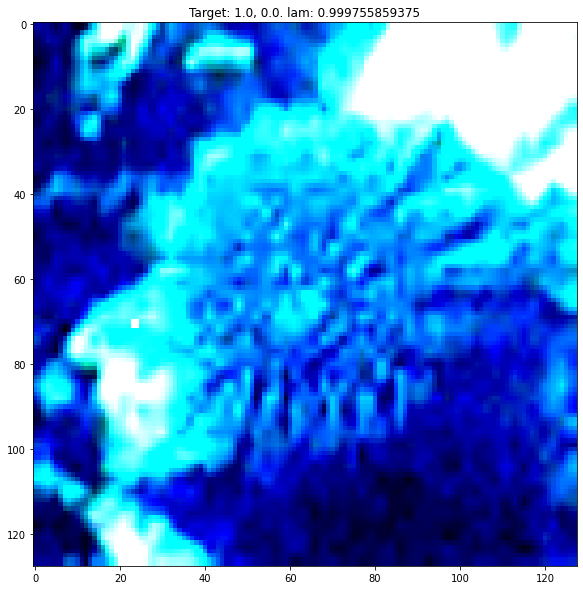

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


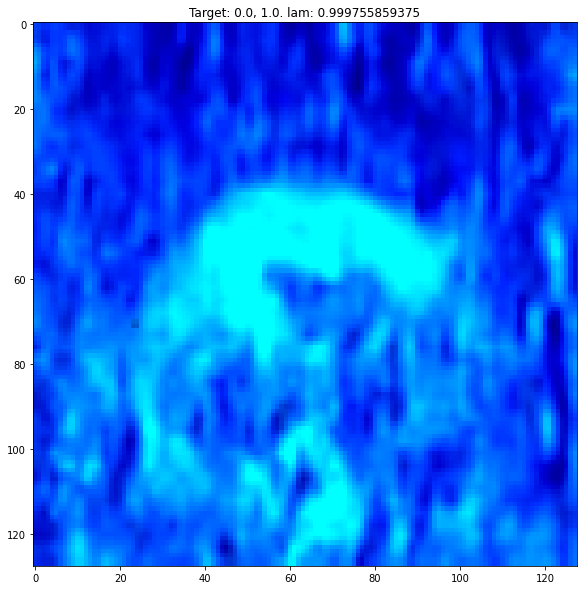

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


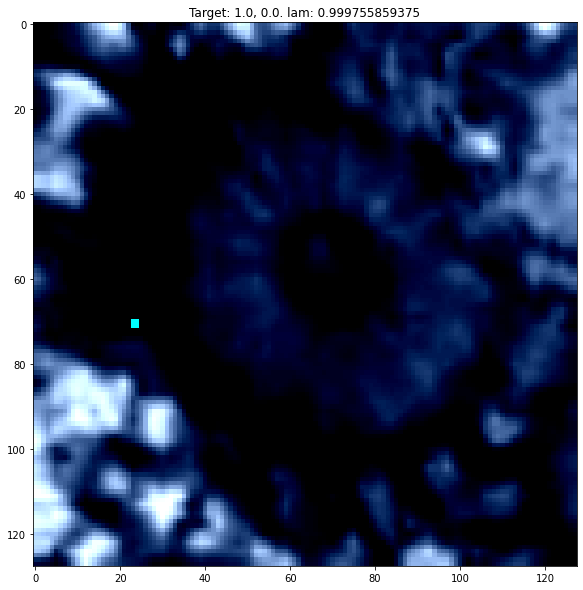

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


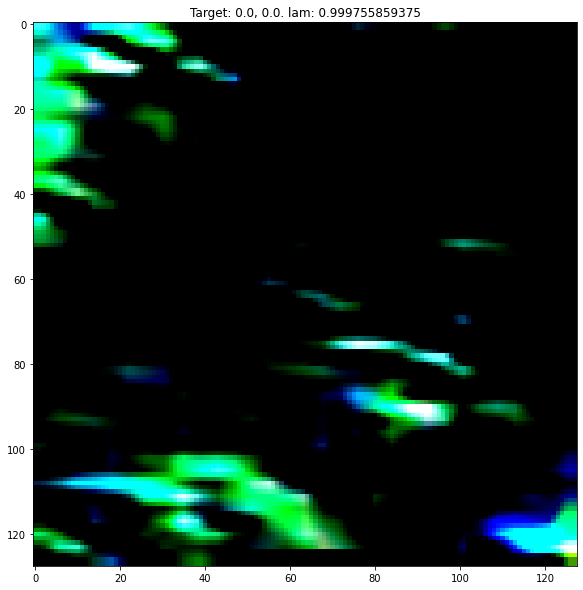

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


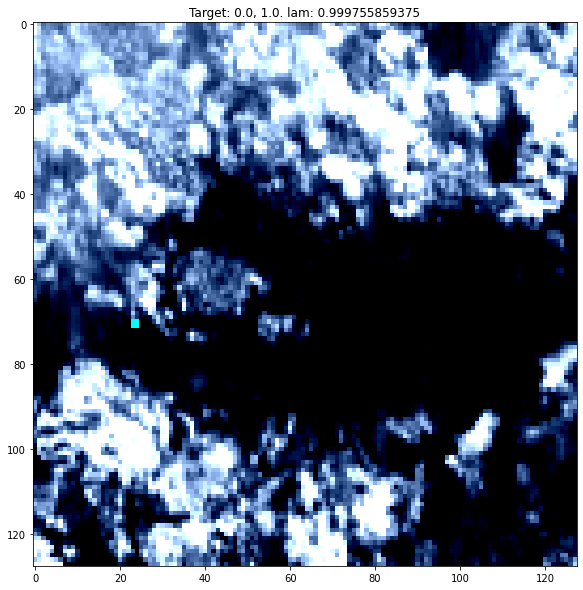

In [ ]:
for idx in np.random.choice(np.arange(BATCH_SIZE), 5):
    # print(train_df.reset_index().loc[idx, 'image_path'])
    plt.figure(figsize=(10,10))
    plt.imshow(mixed_x[idx].permute(1,2,0))
    plt.title(f'Target: {y_a[idx]}, {y_b[idx]}. lam: {lam}')
    plt.show()

# 2. Define model

In [ ]:
import timm
from torch import nn

class COTSClfModel(nn.Module):
    def __init__(self, backbone_name, backbone_pretrained=None, n_classes=1):
        super(COTSClfModel, self).__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=False)
        if backbone_pretrained is not None:
            self.backbone.load_state_dict(torch.load(backbone_pretrained))
        
        if 'nfnet' in backbone_name:
            clf_in_feature = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Linear(clf_in_feature, n_classes)
        elif 'resnet' in backbone_name:
            clf_in_feature = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(clf_in_feature, n_classes)
        else:
            clf_in_feature = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(clf_in_feature, n_classes)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        
        return x
    
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
model = COTSClfModel(candidate['model_architecture'], backbone_pretrained=candidate['backbone_pretrained'])

In [ ]:
count_trainable_params(model)

63789521

In [ ]:
criterion = nn.BCEWithLogitsLoss()
mixup_cutmix_criterion(criterion, torch.rand(BATCH_SIZE), y_a, y_b, lam)

tensor(0.8153)

In [ ]:
# resnet50: 23,510,081
# eca_nfnet_l0 = 21,841,229
# effb7: 63,789,521
# effb5: 28,342,833

In [ ]:
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/Kaggle/COTS/models/resnet50_clf_v6_no_rand_negs/Fold0_resnet50_clf_v6_no_rand_negs_ValidLoss0.141_TrainLoss0.081_Ep02.pth', map_location='cpu'))

In [ ]:
# model.eval()
# model.to(DEVICE)
# print()

# 3. Training loop

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
import gc
from sklearn.metrics import roc_auc_score, accuracy_score, fbeta_score

class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_valid_fn(dataloader,model,criterion,optimizer=None,scaler=None,device='cuda:0',scheduler=None,epoch=0,mode='train'):
    '''Perform model training'''
    if(mode=='train'):
        model.train()
    elif(mode=='valid'):
        model.eval()
    else:
        raise ValueError('No such mode')
        
    loss_score = AverageMeter()
    
    tk0 = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, batch in tk0:
        if(mode=='train'):
            optimizer.zero_grad()
            
            inps, y_a, y_b, lam = batch
            inps = inps.to(device)
            y_a = y_a.to(device)
            y_b = y_b.to(device)
            outputs = model(inps).view(-1)
            with torch.cuda.amp.autocast():
                loss = mixup_cutmix_criterion(criterion, outputs, y_a, y_b, lam)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        elif mode == 'valid':
            inps, y_a = batch
            y_b, lam = None, None
            inps = inps.to(device)
            y_a = y_a.to(device)
            outputs = model(inps).view(-1)
            with torch.cuda.amp.autocast():
                loss = criterion(outputs, y_a)
        else:
            raise ValueError('No such mode')
            
        loss_score.update(loss.detach().cpu().item(), dataloader.batch_size)
        if(mode=='train'):
            tk0.set_postfix(Loss_Train=loss_score.avg, Epoch=epoch, LR=optimizer.param_groups[0]['lr'])
        elif(mode=='valid'):
            tk0.set_postfix(Loss_Valid=loss_score.avg, Epoch=epoch)
    
        del batch, inps, outputs, y_a, y_b, lam, loss
        torch.cuda.empty_cache()
        
    if(mode=='train'):
        if(scheduler.__class__.__name__ == 'CosineAnnealingWarmRestarts'):
            scheduler.step(epoch=epoch)
        elif(scheduler.__class__.__name__ == 'ReduceLROnPlateau'):
            scheduler.step(loss_score.avg)
        elif(scheduler.__class__.__name__ == 'GradualWarmupScheduler'):
            scheduler.step()
    
    return loss_score.avg

def compute_metrics(dataloader, model, device='cuda:0', conf_thresh=0.5):
    model.eval()
    tk0 = tqdm(enumerate(dataloader), total=len(dataloader))
    batch_preds=[]
    batch_labels=[]
    for i, batch in tk0:
        inps, lbls = batch
        inps = inps.to(device)
        with torch.no_grad():
            outputs = model(inps).view(-1)
            probs = torch.sigmoid(outputs)
        batch_preds.append(probs.cpu().numpy())
        batch_labels.append(lbls.numpy())
        
        del batch, inps, outputs, probs
        torch.cuda.empty_cache()
        
    predictions = np.concatenate(batch_preds)
    labels = np.concatenate(batch_labels)
    auc = roc_auc_score(y_true=labels, y_score=predictions, multi_class='ovo', average='macro')
    acc = accuracy_score(y_true=labels, y_pred=(predictions >= conf_thresh).astype(int))
    f2 = fbeta_score(y_true=labels, y_pred=(predictions >= conf_thresh).astype(int), beta=2)
    return auc, acc, f2

In [ ]:
from general import seed_torch, init_progress_dict, log_to_progress_dict, save_progress, log_and_print, get_logger

In [ ]:
for candidate in CANDIDATES:
    seed_torch(SEED) # set seed each time a candidate is run
    print(f"######################### Candidate: {candidate['model_architecture']} ############################")
    run_folds = candidate.get('run_folds', RUN_FOLDS)
    
    ver_note = candidate['ver_note']
    out_folder_name = f"{candidate['model_architecture']}_{ver_note}"
    out_folder = os.path.join(MODEL_DIR, out_folder_name)

    os.makedirs(out_folder, exist_ok=True)
    
    for valid_fold in run_folds:
        seed_torch(SEED) # set seed each time a fold is run
        # Read data
        if(SAMPLE):
            sample_df = clean_obj_df_with_ext.sample(SAMPLE, random_state=SEED)
            train_df = sample_df[sample_df.fold!=valid_fold]
            valid_df = sample_df[sample_df.fold==valid_fold]
        else:
            train_df = clean_obj_df_with_ext[clean_obj_df_with_ext.fold!=valid_fold]
            valid_df = clean_obj_df_with_ext[clean_obj_df_with_ext.fold==valid_fold]

        print(f'\n\n================= Fold {valid_fold} ==================')
        print(f'Number of training images: {len(train_df)}. Number of valid images: {len(valid_df)}')

        # create data loader
        img_size = candidate.get('img_size', IMG_SIZE)
        train_dataset = COTSClfDataset(train_df, get_train_transforms(img_size)) 
        valid_dataset = COTSClfDataset(valid_df, get_valid_transforms(img_size)) 
        
        batch_size = candidate.get('batch_size', BATCH_SIZE)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                                   num_workers=NUM_WORKERS, collate_fn=cutmix_data)
        train_loader_for_eval = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                                   num_workers=NUM_WORKERS)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,
                                                   num_workers=NUM_WORKERS)
        
        # Model
        model = COTSClfModel(candidate['model_architecture'], backbone_pretrained=candidate['backbone_pretrained'])
        
        # print(model)

        warm_start_weight = candidate.get('warm_start_weight')
        if(warm_start_weight):
            print('Load warm start weight:', warm_start_weight)
            model.load_state_dict(torch.load(warm_start_weight, map_location='cpu'))
        model.to(DEVICE)
        print()
        
        # Loss
        criterion = nn.BCEWithLogitsLoss()

        # use amp to accelerate training
        scaler = torch.cuda.amp.GradScaler()

        # Optimizer and scheduler
        base_lr = candidate.get('base_lr', BASE_LR)
        optim = AdamW(model.parameters(), lr=BASE_LR/WARMUP_FACTOR)

        num_training_steps = NUM_EPOCHS * len(train_loader)
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optim, NUM_EPOCHS-1)
        lr_scheduler = GradualWarmupScheduler(optim, multiplier=WARMUP_FACTOR, total_epoch=1, after_scheduler=scheduler_cosine)
        
        # Logging
        logger = get_logger(
            name = f'training_log_fold{valid_fold}.txt',
            path=os.path.join(out_folder, f'training_log_fold{valid_fold}.txt')
        )

        best_valid_loss = 9999
        best_valid_ep = 0
        patience = PATIENCE

        progress_dict = init_progress_dict(['loss', 'AUC', 'accuracy', 'f2'])
        
        start_ep = candidate.get('warm_start_ep', 1)
        print('Start ep:', start_ep)

        for epoch in range(start_ep, NUM_EPOCHS+1):

            # =============== Training ==============
            train_loss = train_valid_fn(train_loader,model,criterion,optimizer=optim,device=DEVICE,
                                        scheduler=lr_scheduler,scaler=scaler,epoch=epoch,mode='train')
            valid_loss = train_valid_fn(valid_loader,model,criterion,device=DEVICE,epoch=epoch,
                                        scaler=scaler,mode='valid')

            # =============== Evaluation =================
            train_auc, train_acc, train_f2 = compute_metrics(train_loader_for_eval, model, DEVICE)
            valid_auc, valid_acc, valid_f2 = compute_metrics(valid_loader, model, DEVICE)
            current_lr = optim.param_groups[0]['lr']
            log_line = f'Model: {out_folder_name}. Epoch: {epoch}.\n'
            log_line += f'Train loss:{train_loss} - Valid loss: {valid_loss}.\n'
            log_line += f'Train AUC:{train_auc} - Valid AUC: {valid_auc}.\n'
            log_line += f'Train accuracy:{train_acc} - Valid accuracy: {valid_acc}.\n'
            log_line += f'Train f2:{train_f2} - Valid f2: {valid_f2}.\n'
            log_line += f'Lr: {current_lr}.\n'

            log_and_print(logger, log_line)

            metric_dict = {'train_loss':train_loss,'valid_loss':valid_loss,'train_AUC':train_auc, 'valid_AUC':valid_auc,
                          'train_accuracy':train_acc, 'valid_accuracy':valid_acc, 'train_f2':train_f2, 'valid_f2':valid_f2}
            progress_dict = log_to_progress_dict(progress_dict, metric_dict)

            # plot figure and save the progress chart
            save_progress(progress_dict, out_folder, out_folder_name, valid_fold, show=False)

            # plot figure and save the progress chart
            save_progress(progress_dict, out_folder, out_folder_name, valid_fold, show=False)

            if(valid_loss < best_valid_loss):
                best_valid_loss = valid_loss
                best_valid_ep = epoch
                patience = PATIENCE # reset patience

                # save model
                name = os.path.join(out_folder, 'Fold%d_%s_ValidLoss%03.03f_TrainLoss%03.03f_Ep%02d.pth'%(valid_fold, out_folder_name, valid_loss, train_loss, epoch))
                log_and_print(logger, 'Saving model to: ' + name)
                torch.save(model.state_dict(), name)
            else:
                patience -= 1
                log_and_print(logger, 'Decrease early-stopping patience by 1 due valid loss not decreasing. Patient='+ str(patience))

            if(patience == 0):
                log_and_print(logger, 'Early stopping patience = 0. Early stop')
                break

######################### Candidate: tf_efficientnet_b7_ns ############################


================= Fold 2 ==================
Number of training images: 42032. Number of valid images: 7603


/usr/local/lib/python3.6/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.6/dist-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)



Start ep: 1


 58%|█████▊    | 192/329 [23:39<16:57,  7.42s/it, Epoch=1, LR=1e-5, Loss_Train=0.644]